In [16]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import seaborn as sns

In [5]:
ogdf = pd.read_csv('creditcard.csv').dropna()

In [6]:
ogdf.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Ok, first things, first - it would be great if we could establish what these features actually are. Let's check here:

https://www.kaggle.com/mlg-ulb/creditcardfraud

Ok, so we can't get this information due to confidentiality reasons. Further to that it seems we have huge class imbalance so let's try to address that first:

In [12]:
print(ogdf['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64


There's a number of approaches we could take here. We could down sample the majority class, this is a simple approach and allows us considerable freedom to utilize a number of models. The downside of down sampling the majority class is that it substantially decreases our sample size and our statistical power. The other approach we could take is using a decision tree based model. Decision tree based models work well in this context due to the fact that they use an inherently heirarchially structure system of decisions which can learn from both cases somewhat indepedently of they're representation in the dataset. Let's try to apply the gradient boosting model here.

# Rudimentary data exploration:

In [13]:
correlationmatrix = ogdf.corr()

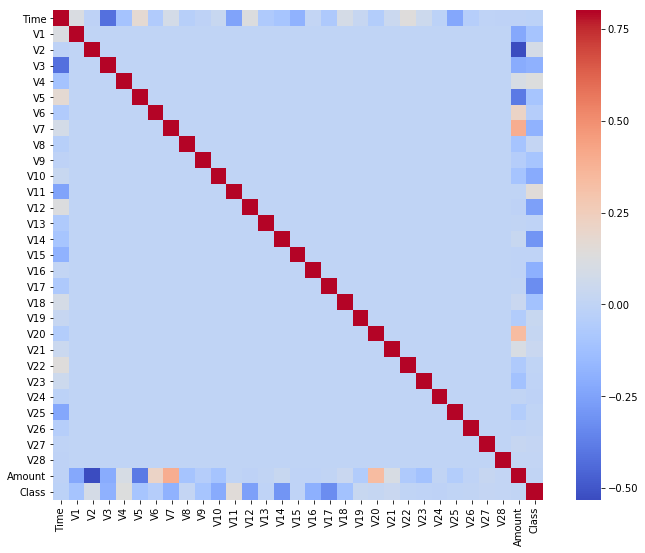

In [17]:
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(correlationmatrix, vmax=.8, square=True, cmap='coolwarm')
plt.show()

This isn't super informative...let's look at how the data correlates specifically with our outcome variable.

In [19]:
print(correlationmatrix['Class'].abs().sort_values(ascending=False))

Class     1.000000
V17       0.326481
V14       0.302544
V12       0.260593
V10       0.216883
V16       0.196539
V3        0.192961
V7        0.187257
V11       0.154876
V4        0.133447
V18       0.111485
V1        0.101347
V9        0.097733
V5        0.094974
V2        0.091289
V6        0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Time      0.012323
V28       0.009536
V24       0.007221
Amount    0.005632
V13       0.004570
V26       0.004455
V15       0.004223
V25       0.003308
V23       0.002685
V22       0.000805
Name: Class, dtype: float64


Ok, there's plenty to work with here. We could drop V13, V26, V15, V25, V23, V22, Amount (?), V24, V28, Time....let's consider doing this. It will reduce the work on the model and increase consistency among the different models.

In [20]:
newdf = ogdf[['Class', 'V17', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18', 'V1', 'V9', 'V5', 'V2', 'V6', 'V21', 'V19', 'V20', 'V8', 'V27', 'Time' ]]

This will do for now, any variable with a less than 1% correlation with the outcome variable was dropped.

# Let's build our model:

First things first, let's run this with low max depth and a varying number of estimators to get the lay of the land

In [23]:
X=newdf.drop('Class', 1)
y=newdf['Class']

# Create training and test sets.
offset = int(X.shape[0] * 0.6)

# Put 60% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 40% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [24]:
n_est= [100, 200, 400, 800, 1600]
# Initialize and fit the model.
for n in n_est:
    clf = ensemble.GradientBoostingClassifier(n_estimators=n, max_depth=2, loss='deviance')
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

# Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
    'maxdepth={}\n'
    'estimators={}\n'
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    ).format(2, n, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


maxdepth=2
estimators=100
Training set accuracy:
Percent Type I errors: 5.851922941878702e-06
Percent Type II errors: 0.0013810538142833735
Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0010182316125804272


maxdepth=2
estimators=200
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0014454249666440392
Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.001062120906226135


maxdepth=2
estimators=400
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0014454249666440392
Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.001062120906226135


maxdepth=2
estimators=800
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0014454249666440392
Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.001062120906226135


maxdepth=2
estimators=1600
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.001445424966644039

Looks like we've struck gold here. Model is accurate, not overfit. Let's  finalize with the following settings and then cross check:
estimators=200
maxdepth=2
lossfunction=deviance

In [25]:
clf = ensemble.GradientBoostingClassifier(n_estimators=200, max_depth=2, loss='deviance')
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
'maxdepth={}\n'
'estimators={}\n'
'Training set accuracy:\n'
'Percent Type I errors: {}\n'
'Percent Type II errors: {}\n'
'Test set accuracy:\n'
'Percent Type I errors: {}\n'
'Percent Type II errors: {}\n\n'
).format(2, n, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


maxdepth=2
estimators=1600
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0014454249666440392
Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.001062120906226135




In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X, y, cv=5)

array([0.00547734, 0.99833222, 0.99894665, 0.99834975, 0.9984902 ])

There something really strange going on with the first cross validation - likely due to under sampling. 
Other 4 came out fine so i'm going to proceed here.

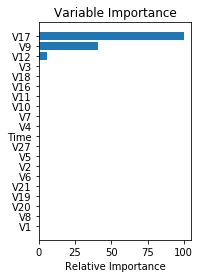

In [29]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_featureimportance = np.argsort(feature_importance)
pos = np.arange(sorted_featureimportance.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_featureimportance], align='center')
plt.yticks(pos, X.columns[sorted_featureimportance])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

V17, V9 are the most important with the other contributing very little. Based on this we could likley run SVM here also.